In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import librosa.display
from sklearn import metrics
from glob import glob
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display
import noisereduce as nr
import io
import time
from tqdm import tqdm
from scipy.stats import kurtosis
from tabulate import tabulate
from keras.utils import load_img, img_to_array
from joblib import load
import PIL
from PIL import Image

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
ENTERFACE_DIR = './../../../eNTERFACE05_Dataset/'
ENTERFACE_EXTRACTED_FEATURES_FILE = './../../enterface05/final_data/traditional/final_preprocessed_extracted_features_ent05.csv'
EMODB_DIR = './../../../EMO-DB_Dataset/wav/'
EMODB_EXTRACTED_FEATURES_FILE = './../../emodb/traditional/preprocessed_extracted_features_emodb.csv'
CREMAD_DIR = './../../../CREMA-D_Dataset/AudioWAV/'
CREMAD_EXTRACTED_FEATURES_FILE = './../../cremad/traditional/preprocessed_extracted_features_cremad.csv'
plt.rcParams['figure.dpi'] = 300

In [3]:
def get_metrics(y_labels, y_pred, times, draw_corr_matrix=True, all_emotions=False):
    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Average Prediction Time",
            f"{round(np.mean(times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        if all_emotions:
            ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        else:
            ticks = ['0 - angry', '1 - happy', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()




In [4]:
def preprocess_audio(y, sr):
    y = nr.reduce_noise(y=y, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)
    y, _ = librosa.effects.trim(y, top_db=30)
    return y
    
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1
    
    return num_spikes

def extract_features(audio_file, preprocess=True): 
    y, sr = librosa.load(audio_file, sr=16000)
    
    if preprocess:
        y = preprocess_audio(y, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    zcr = librosa.feature.zero_crossing_rate(y=y)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=127)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    min_zcr = np.min(zcr)
    spikes_zcr = spikes(zcr)
    var_mel_spect = np.var(mel_spect)
    spikes_mel_spect = spikes(mel_spect)
    thpercentile25_chroma_stft = np.percentile(chroma_stft, 0.25)
    spikes_chroma_stft = spikes(chroma_stft)
    mean_spec_bw = np.mean(spec_bw)
    max_spec_bw = np.max(spec_bw)
    thpercentile25_rms = np.percentile(librosa.feature.rms(y=y), 0.25)

    var_mfcc1 = np.var(mfcc[0])
    var_mfcc3 = np.var(mfcc[2])
    max_mfcc5 = np.max(mfcc[4])
    var_mfcc5 = np.var(mfcc[4])
    median_mfcc5 = np.median(mfcc[4])
    spikes_mfcc6 = spikes(mfcc[5])
    thpercentile75_mfcc7 = np.percentile(mfcc[6], 0.75)
    max_mfcc7 = np.max(mfcc[6])
    var_mfcc8 = np.var(mfcc[7])
    sum_mfcc10 = np.sum(mfcc[9])
    max_mfcc10 = np.max(mfcc[9])
    thpercentile75_mfcc11 = np.percentile(mfcc[10], 0.75)
    max_mfcc11 = np.max(mfcc[10])
    sum_mfcc12 = np.sum(mfcc[11])
    kurtosis_mfcc12 = kurtosis(mfcc[11])
    mean_mfcc13 = np.mean(mfcc[12])
    mean_mfcc15 = np.mean(mfcc[14])
    spikes_mfcc16 = spikes(mfcc[15])
    kurtosis_mfcc17 = kurtosis(mfcc[16])
    mean_mfcc17 = np.mean(mfcc[16])
    kurtosis_mfcc18 = kurtosis(mfcc[17])
    spikes_mfcc19 = spikes(mfcc[18])
    mean_mfcc19 = np.mean(mfcc[18])
    mean_mfcc20 = np.mean(mfcc[19])

    return np.array([min_zcr, spikes_zcr, var_mel_spect, spikes_mel_spect, thpercentile25_chroma_stft,
        spikes_chroma_stft, mean_spec_bw, max_spec_bw, thpercentile25_rms, var_mfcc1, var_mfcc3, max_mfcc5,
        var_mfcc5, median_mfcc5, spikes_mfcc6, thpercentile75_mfcc7, max_mfcc7, var_mfcc8,
        sum_mfcc10, max_mfcc10, thpercentile75_mfcc11, max_mfcc11, sum_mfcc12, kurtosis_mfcc12,
        mean_mfcc13, mean_mfcc15, spikes_mfcc16, kurtosis_mfcc17, mean_mfcc17, kurtosis_mfcc18,
        spikes_mfcc19, mean_mfcc19, mean_mfcc20]).reshape(1, -1)

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0, dpi=100)
    buf.seek(0)
    return Image.open(buf).convert('RGB').resize((224, 224), PIL.Image.NEAREST)

def extract_dl_features(audio_file, preprocess=True): 
    y, sr = librosa.load(audio_file, sr=16000)

    if preprocess:
        y = preprocess_audio(y, sr)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(y,  n_fft=2048, hop_length=512)), ref=np.max)
    librosa.display.specshow(spec, sr=sr, hop_length=512, ax=ax, cmap="viridis_r")
    img = fig2img(fig)
    fig.clf()
    plt.close(fig)

    return tf.keras.applications.resnet50.preprocess_input(
        img_to_array(img)).reshape((1, 224, 224, 3))


# eNTERFACE'05

In [15]:
emotion_number = {
    'anger': 0, 'happiness': 1, 'sadness': 2
}

print(f"Number of Audio Files: {pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 630


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
happiness,1,210
sadness,3,210


## Traditional Model

100%|██████████| 1260/1260 [02:44<00:00,  7.67it/s]


Metric                     Value
-----------------------  -------
Accuracy                  46.03
F1 score macro            44.26
Precision                 47.14
Recall                    46.03
Matthews corrcoef          0.203
Average Prediction Time    0.26

              precision    recall  f1-score   support

           0       0.42      0.70      0.52       210
           1       0.30      0.18      0.22       210
           2       0.70      0.50      0.58       210

    accuracy                           0.46       630
   macro avg       0.47      0.46      0.44       630
weighted avg       0.47      0.46      0.44       630



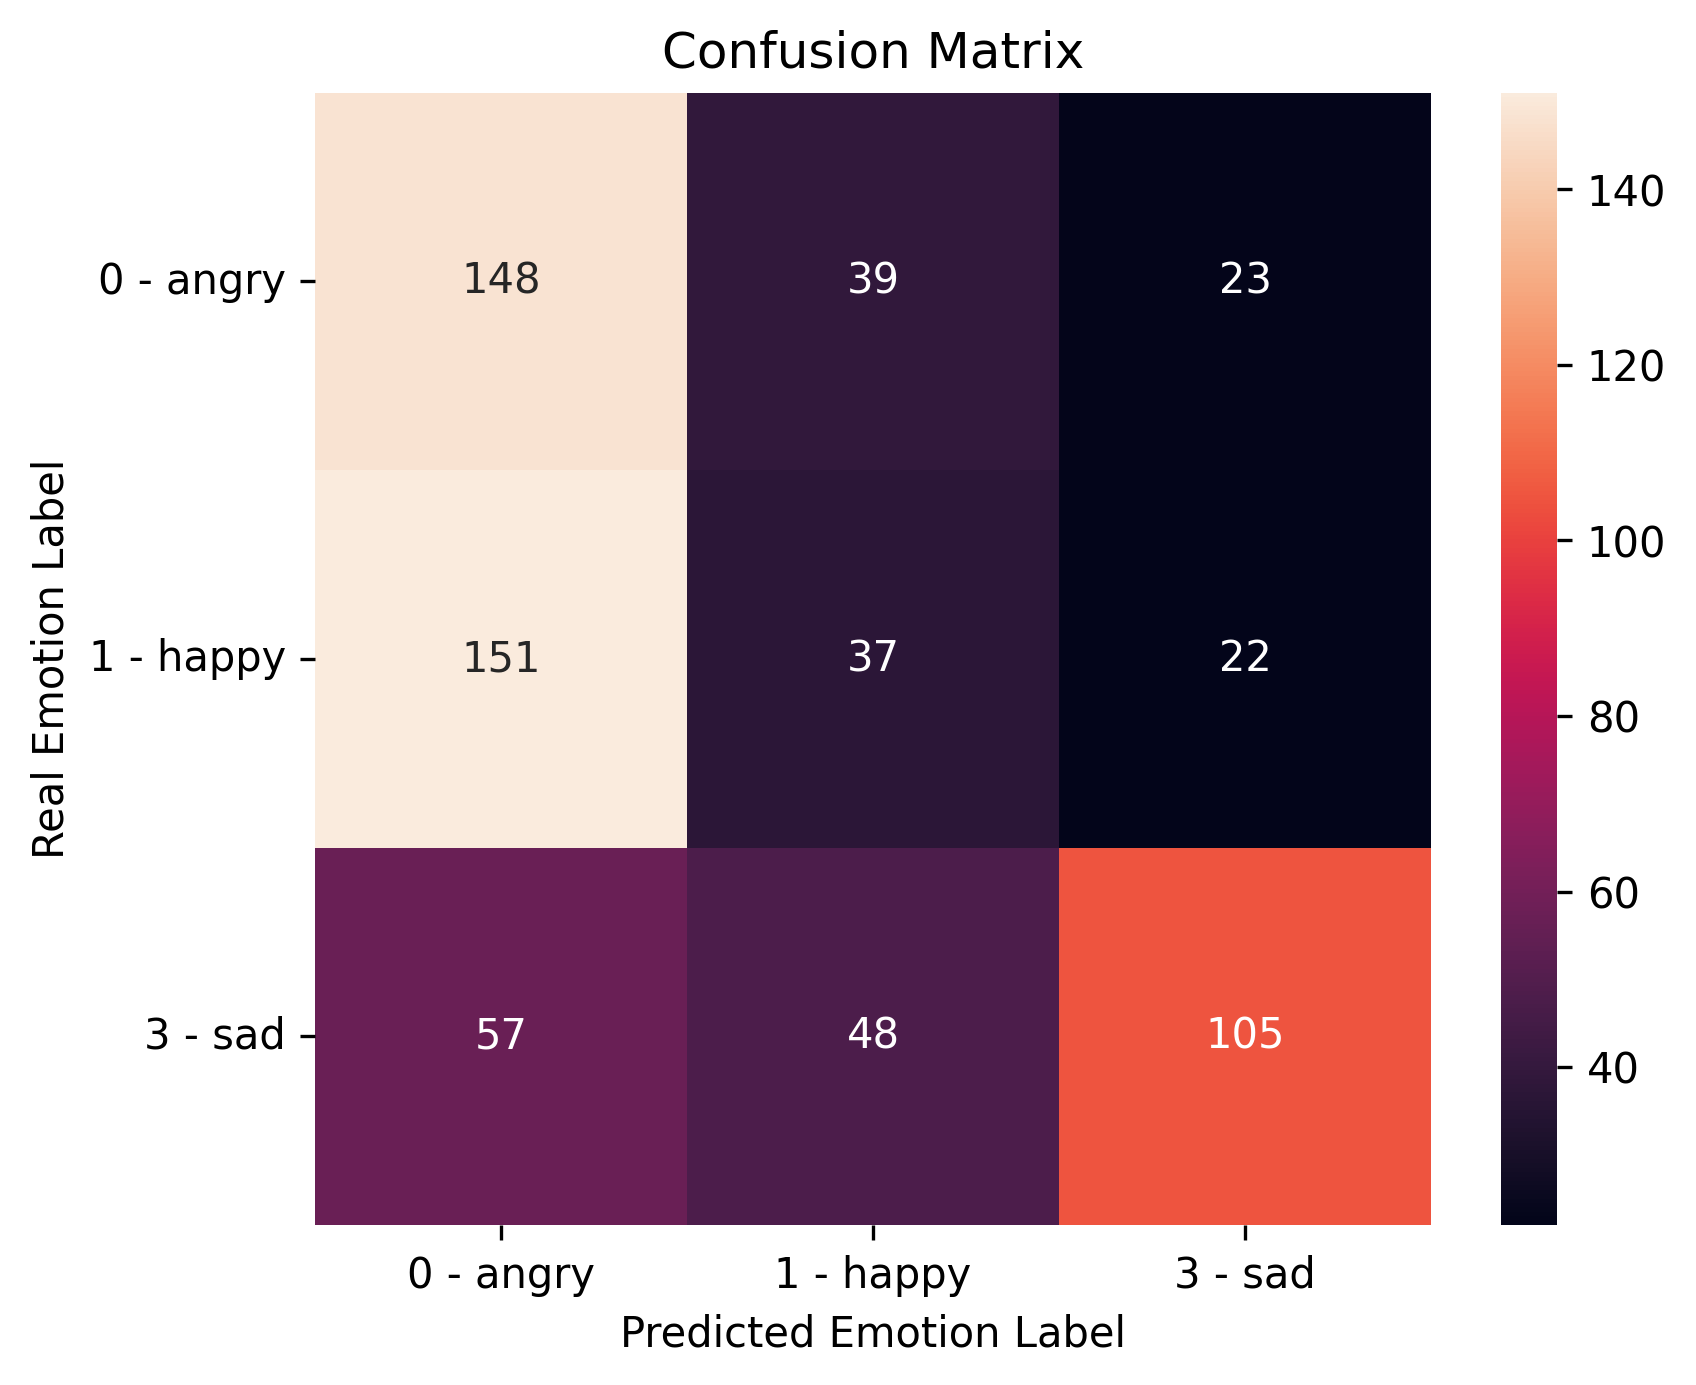

In [16]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob("../../../eNTERFACE05_Dataset/*/*/*/*.wav")):
    emotion = file_path.split('\\')[-3]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(2 if pred == 3 else pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

## Deep Learning Model

100%|██████████| 1260/1260 [02:50<00:00,  7.38it/s]


Metric                     Value
-----------------------  -------
Accuracy                  41.27
F1 score macro            38.3
Precision                 52.13
Recall                    41.27
Matthews corrcoef          0.131
Average Prediction Time    0.27

              precision    recall  f1-score   support

           0       0.42      0.62      0.50       210
           1       0.35      0.48      0.40       210
           2       0.79      0.14      0.24       210

    accuracy                           0.41       630
   macro avg       0.52      0.41      0.38       630
weighted avg       0.52      0.41      0.38       630



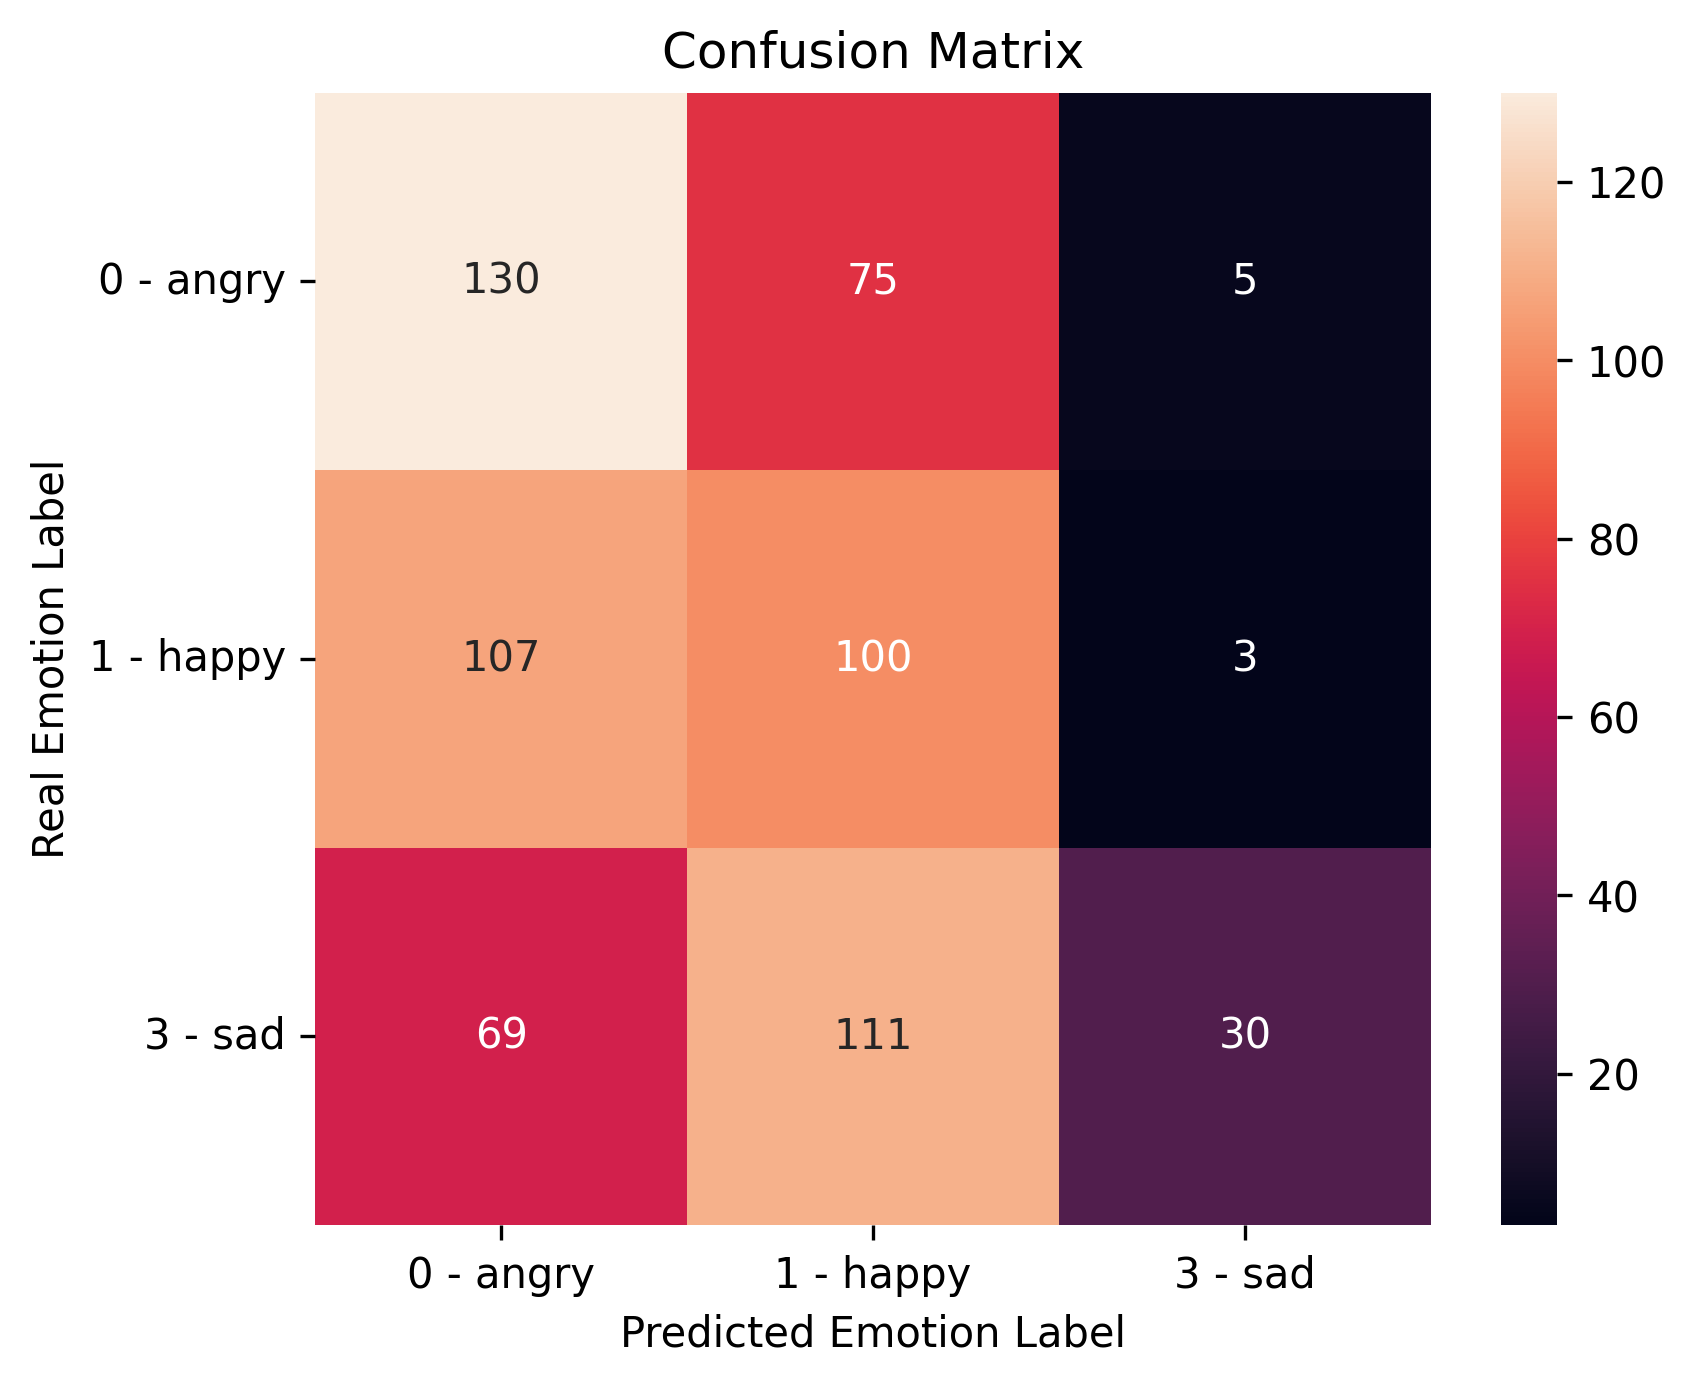

In [7]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob("../../../eNTERFACE05_Dataset/*/*/*/*.wav")):
    emotion = file_path.split('\\')[-3]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    pred = list(pred).index(max(pred))
    times.append(end_time)
    y_pred.append(2 if pred == 3 else pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

# EMO-DB

In [8]:
emotion_number = {
    'W': 0, 'F': 1, 'N': 2, 'T': 3
}

print(f"Number of Audio Files: {pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 339


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,127
happy,1,71
neutral,2,79
sad,3,62


## Traditional Model

100%|██████████| 535/535 [00:37<00:00, 14.39it/s]


Metric                     Value
-----------------------  -------
Accuracy                  38.94
F1 score macro            17.52
Precision                 25.75
Recall                    26.81
Matthews corrcoef          0.088
Average Prediction Time    0.11

              precision    recall  f1-score   support

           0       0.42      1.00      0.60       127
           1       0.11      0.06      0.07        71
           2       0.00      0.00      0.00        79
           3       0.50      0.02      0.03        62

    accuracy                           0.39       339
   macro avg       0.26      0.27      0.18       339
weighted avg       0.27      0.39      0.24       339




C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

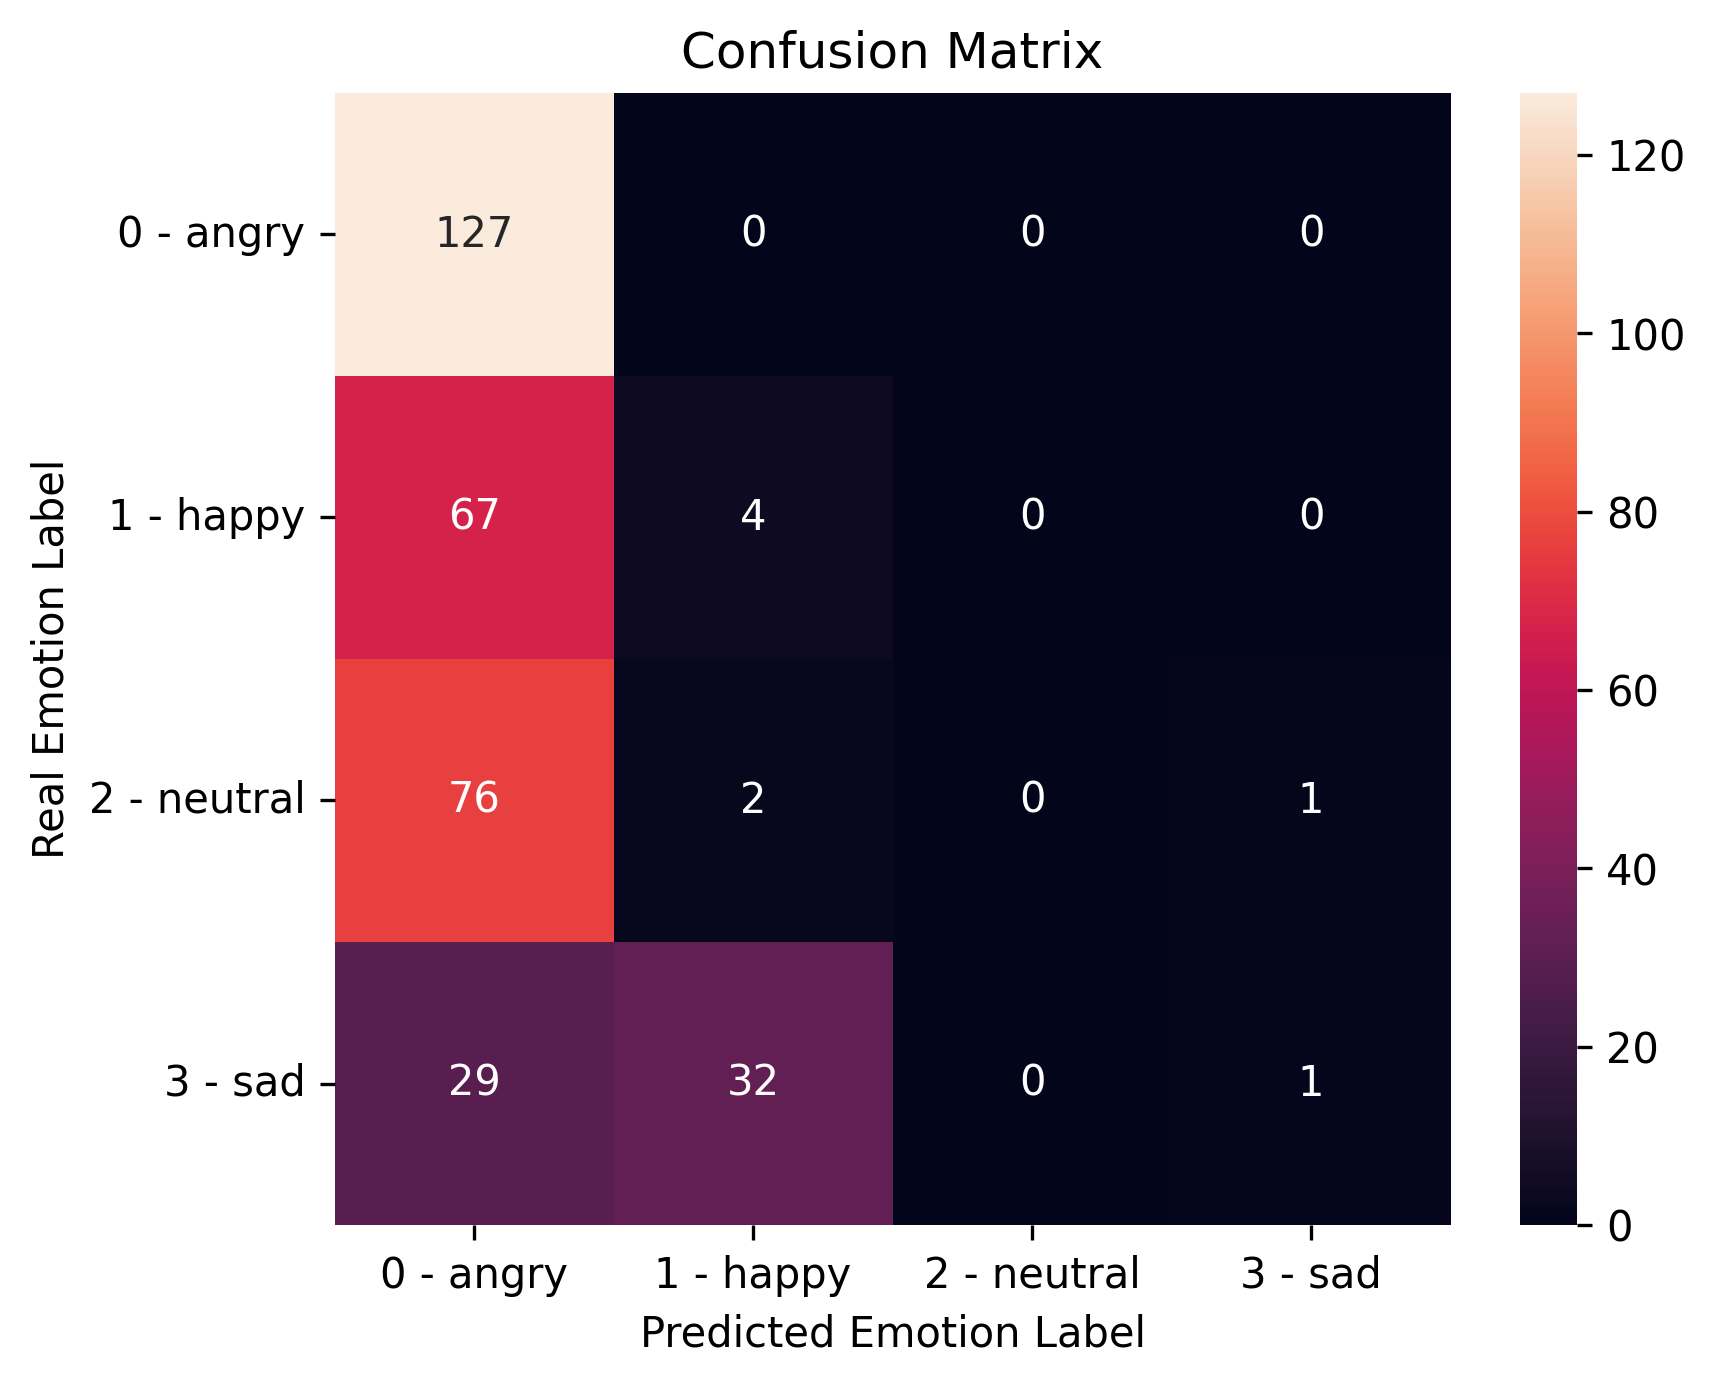

In [9]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{EMODB_DIR}*.wav")):
    emotion = file_path[-6:-5]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times, all_emotions=True)

## Deep Learning Model

100%|██████████| 535/535 [01:07<00:00,  7.95it/s]
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t


Metric                     Value
-----------------------  -------
Accuracy                  37.76
F1 score macro            14.56
Precision                 12.78
Recall                    25.35
Matthews corrcoef          0.039
Average Prediction Time    0.2

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       127
           1       0.12      0.01      0.03        71
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00        62

    accuracy                           0.38       339
   macro avg       0.13      0.25      0.15       339
weighted avg       0.17      0.38      0.21       339



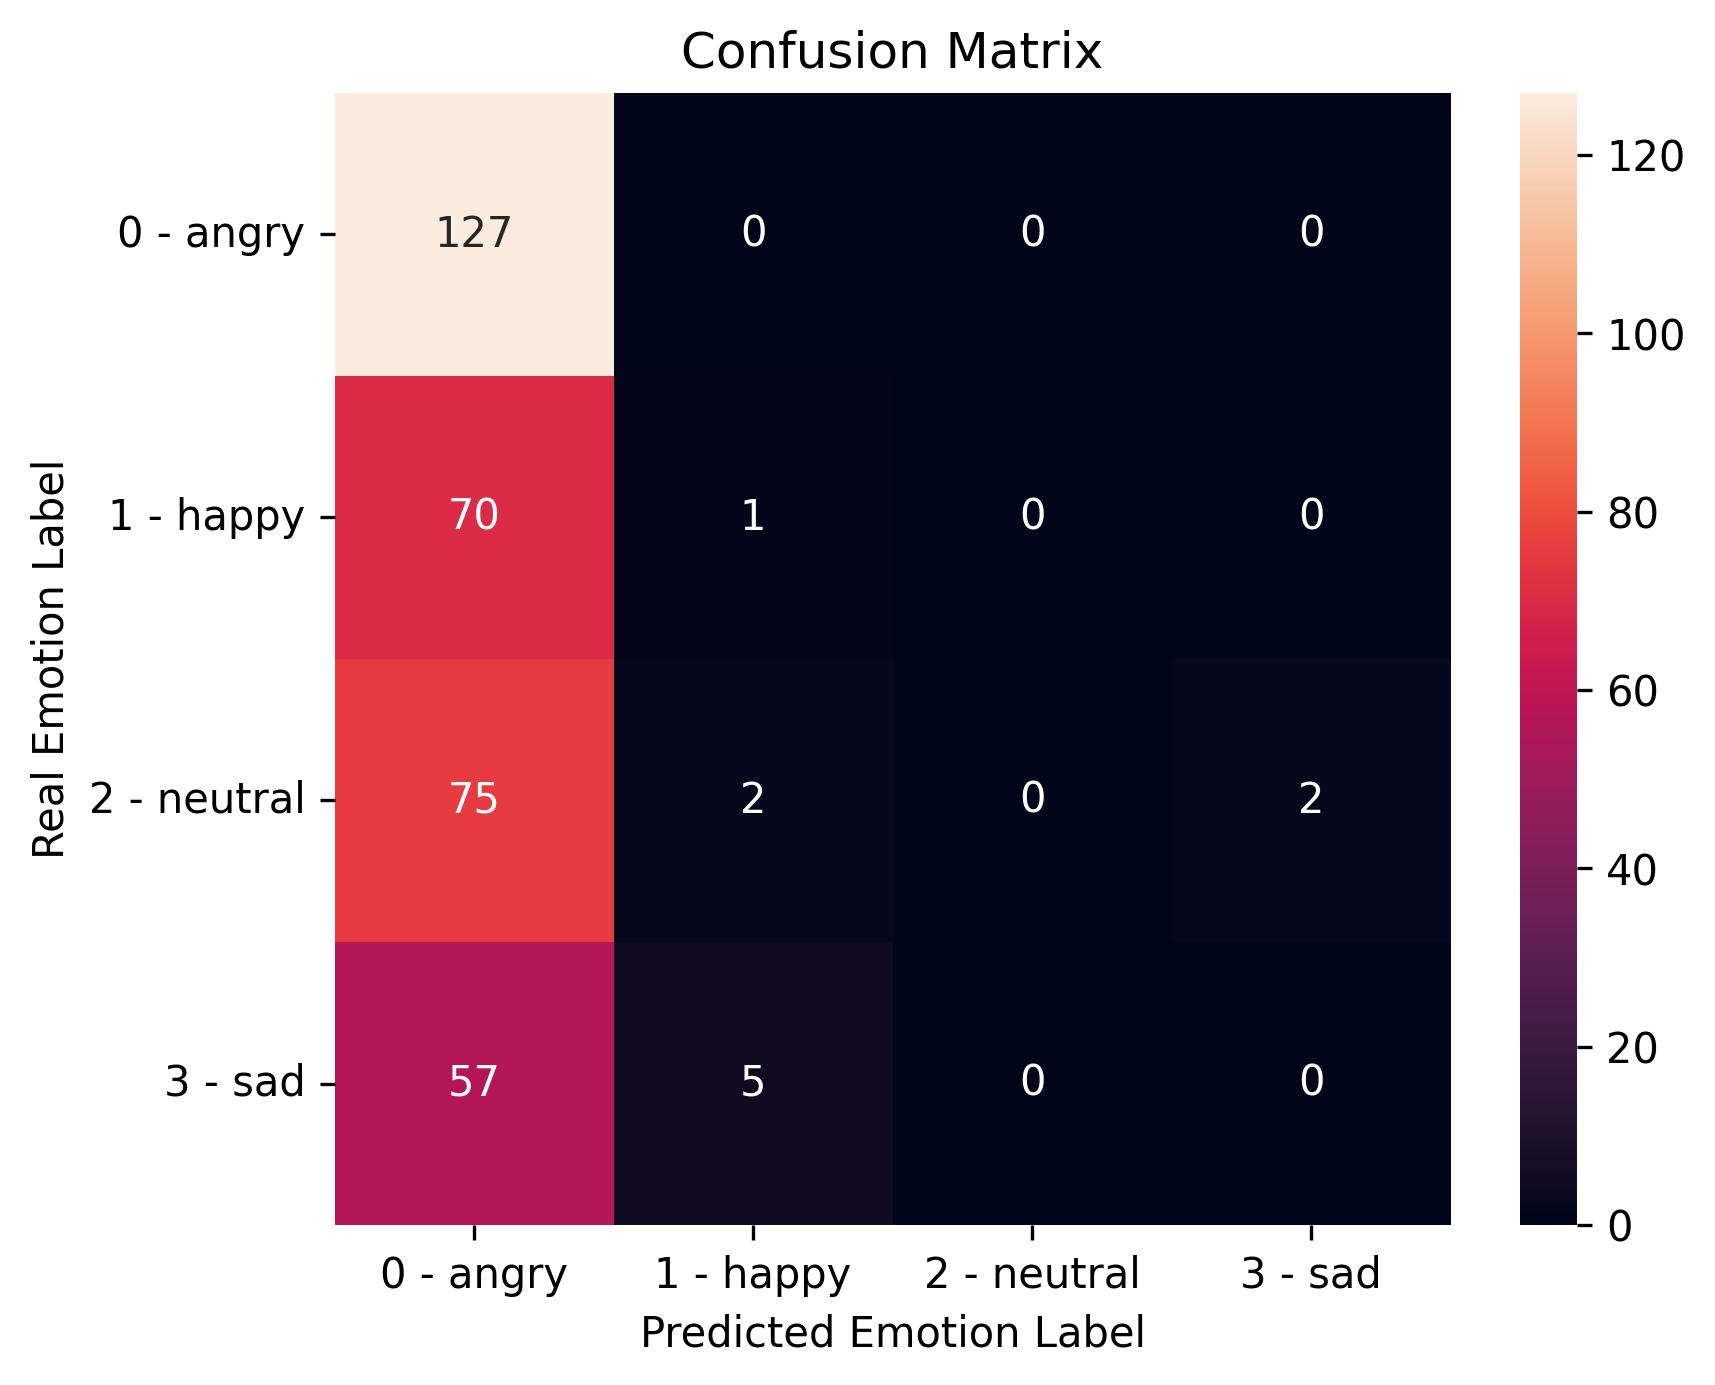

In [10]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{EMODB_DIR}*.wav")):
    emotion = file_path[-6:-5]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times, all_emotions=True)

# CREMA-D

In [11]:
emotion_number = {
    'ANG': 0, 'HAP': 1, 'NEU': 2, 'SAD': 3
}

print(f"Number of Audio Files: {pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 4898


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,1271
happy,1,1271
neutral,2,1087
sad,3,1269


## Traditional Model

100%|██████████| 7441/7441 [08:38<00:00, 14.35it/s]



Metric                     Value
-----------------------  -------
Accuracy                   48.88
F1 score macro             37.41
Precision                  40.01
Recall                     47.13
Matthews corrcoef           0.37
Average Prediction Time     0.11

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1271
           1       0.56      0.14      0.22      1271
           2       0.00      0.00      0.00      1087
           3       0.41      0.97      0.57      1269

    accuracy                           0.49      4898
   macro avg       0.40      0.47      0.37      4898
weighted avg       0.42      0.49      0.39      4898



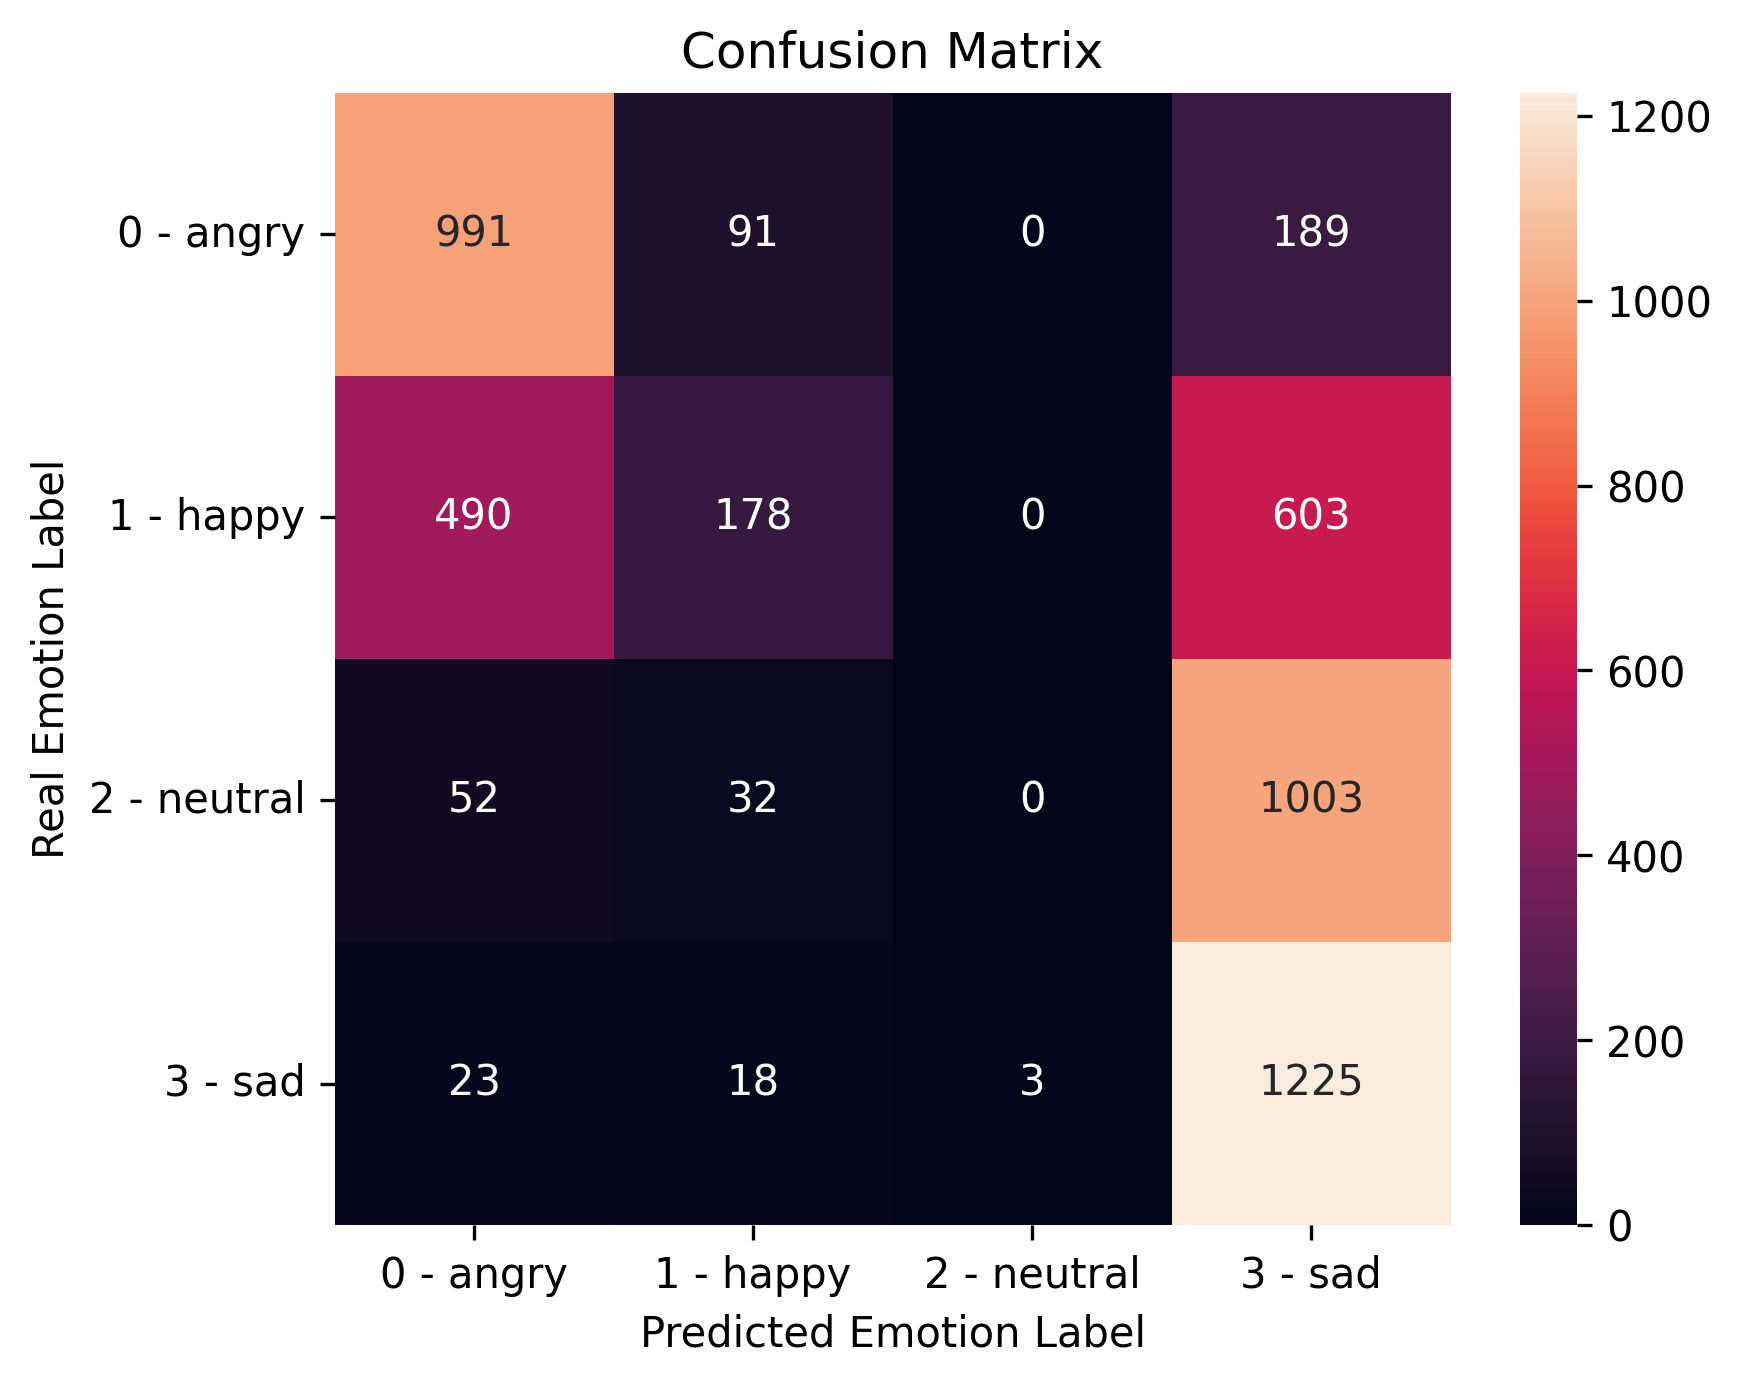

In [12]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{CREMAD_DIR}*.wav")):
    emotion = file_path[-10:-7]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times, all_emotions=True)

## Deep Learning Model

100%|██████████| 7441/7441 [49:07<00:00,  2.52it/s]



Metric                     Value
-----------------------  -------
Accuracy                  39.61
F1 score macro            33.84
Precision                 34.91
Recall                    39.97
Matthews corrcoef          0.216
Average Prediction Time    0.6

              precision    recall  f1-score   support

           0       0.55      0.88      0.68      1271
           1       0.44      0.17      0.25      1271
           2       0.28      0.50      0.36      1087
           3       0.12      0.04      0.06      1269

    accuracy                           0.40      4898
   macro avg       0.35      0.40      0.34      4898
weighted avg       0.35      0.40      0.34      4898



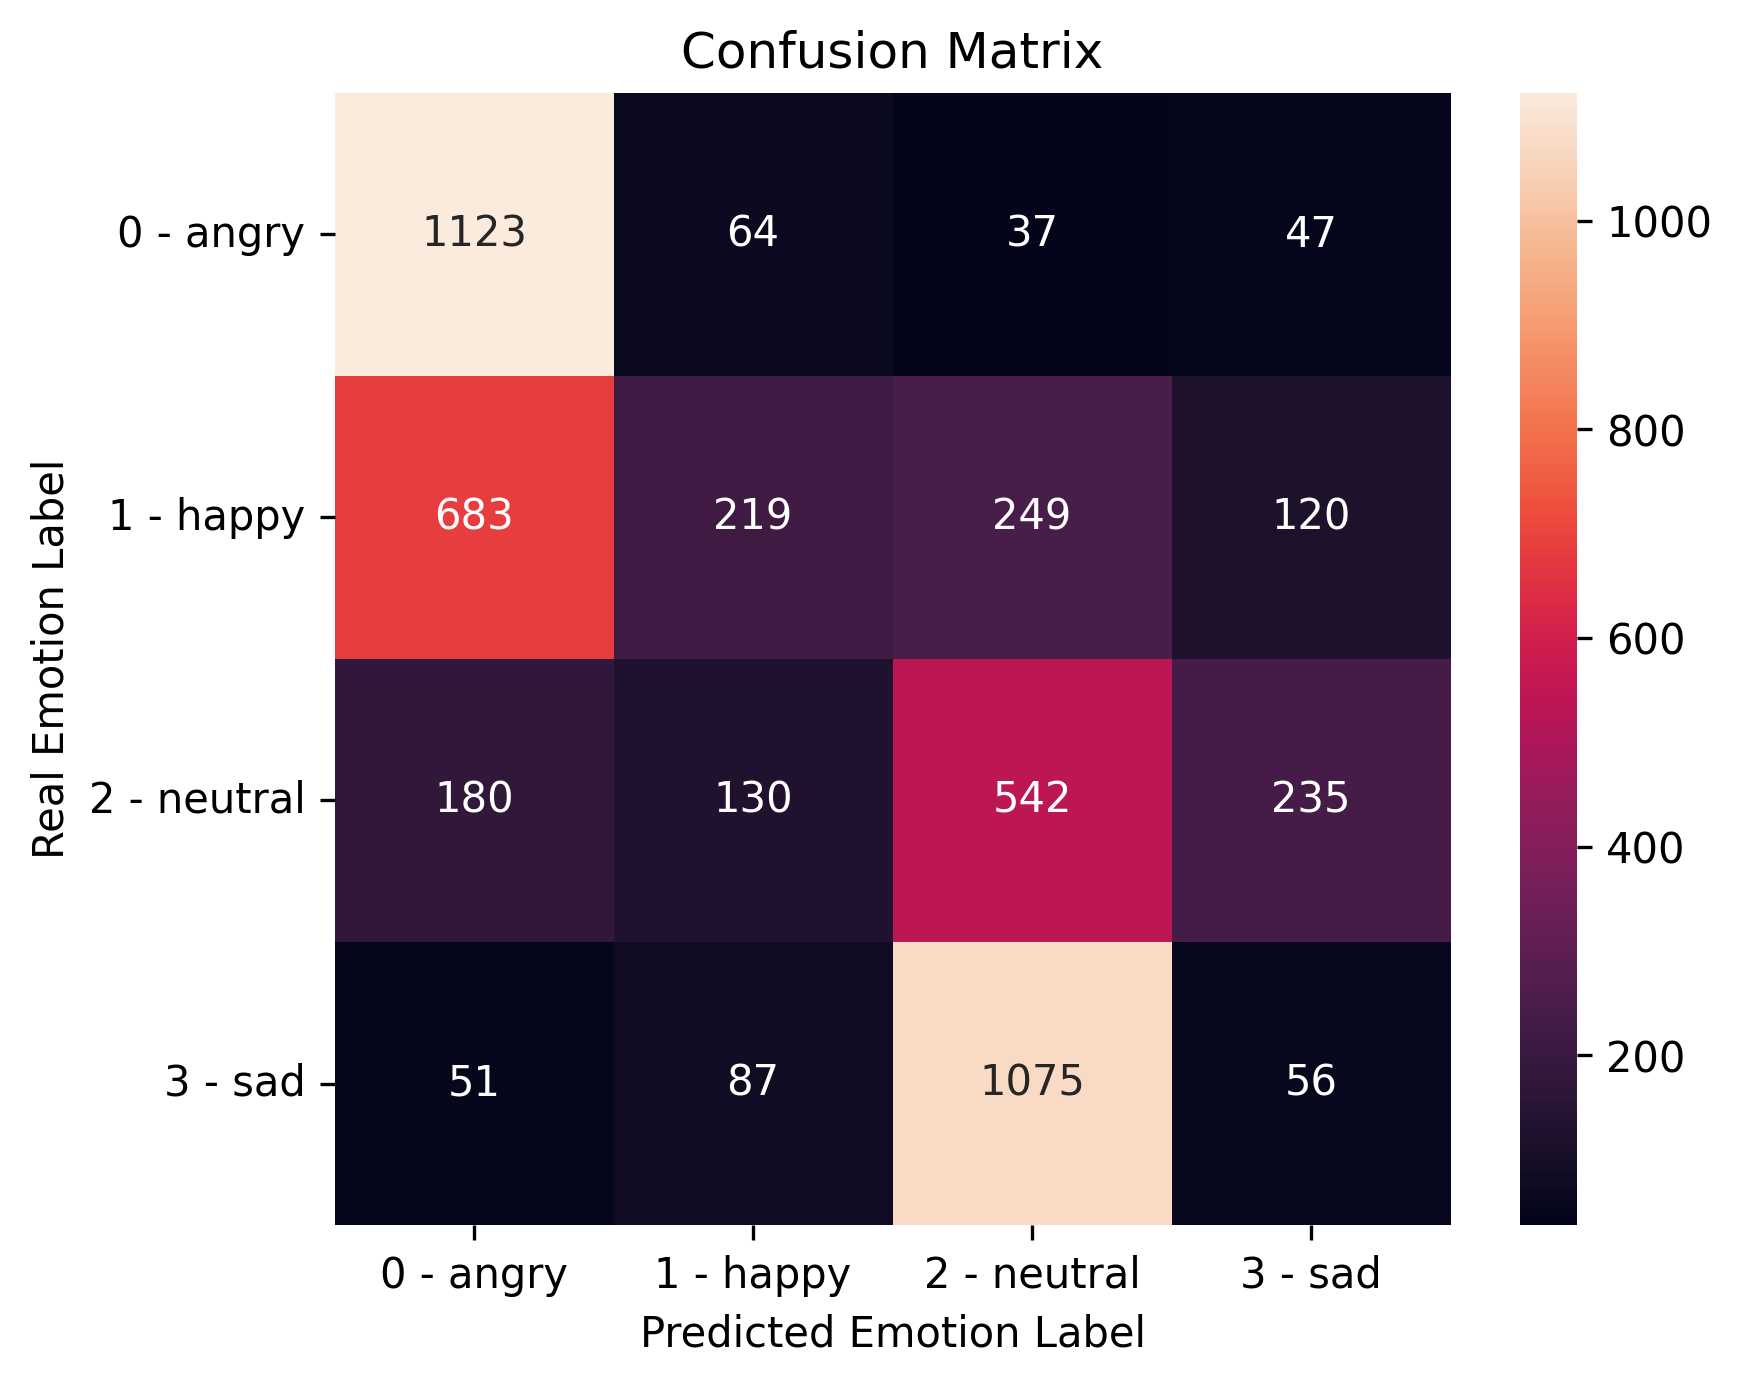

In [13]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{CREMAD_DIR}*.wav")):
    emotion = file_path[-10:-7]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times, all_emotions=True)